Inspired by **CNN Exercise - Deep Learning for Computer Vision** on [Kaggle](https://www.kaggle.com/code/mgmarques/cnn-exercise-deep-learning-for-computer-vision) 

In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from trainers import ClassifierTrainer
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import random

In [2]:
class CIFARDataset(Dataset):

    def __init__(self,path,filenames):
        self.data_dict = self.load_data(path,filenames)
        self.class_names = self.unpickle(os.path.join(path,'batches.meta'))[b'label_names']
        self.class_names = list(map(lambda x: x.decode('UTF-8'), self.class_names))
        self.images = torch.tensor(self.data_dict[b'data'].reshape(-1,3,32,32))/255
        self.labels = torch.tensor(self.data_dict[b'labels'])
        
    def __getitem__(self,index):
        # Get one item from the dataset
        return self.images[index], self.labels[index]
    
    def __len__(self):
        return len(self.images)
    
    def load_data(self,path,filenames):
        data_dict = {}
        for filename in filenames:
            batch_dict = self.unpickle(os.path.join(path_data,filename))
            if len(data_dict)==0:
                data_dict = batch_dict
            else:
                data_dict[b'labels'] += batch_dict[b'labels']  
                data_dict[b'data'] = np.vstack((data_dict[b'data'],batch_dict[b'data']))
        return data_dict
    
    def unpickle(self,file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

In [3]:
def show_sample_image(dataset, idx=0, add_title=True, ax=None):
    image, label = dataset[idx]
    label = label.item()
    image = image.numpy().T
    flipped_image = np.zeros(image.shape)
    flipped_image[:,:, 0] = image[:,:, 0].T
    flipped_image[:,:, 1] = image[:,:, 1].T
    flipped_image[:,:, 2] = image[:,:, 2].T
    label_name = dataset.class_names[label]
    if ax is None:
        _, ax = plt.subplots(figsize=(1,1))
    ax.imshow(flipped_image, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    if add_title:
        ax.set_title(label_name)
    return flipped_image, label, label_name, ax

In [4]:
class CIFARCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3,stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(in_features=8192, out_features=1024)
        self.droput = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=1024, out_features=10)
    
    def init_model_params(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

        
    def forward(self,x):
        
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)
        out = out.view(-1,8192)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc2(out)
        
        return out

# Setup the datasets

In [5]:
path_data = './data/cifar-10-batches-py/'
batchfiles = os.listdir(path_data)
train_batches = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
test_batches = ['test_batch']

batch_size = 100

In [6]:
train_dataset = CIFARDataset(path_data, train_batches)
test_dataset = CIFARDataset(path_data, test_batches)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

# Train the mdel

In [7]:
#Initialize the model
model = CIFARCNN()
#Define the optimizer
optimizer = torch.optim.Adadelta(model.parameters(), lr = 0.01)
#Check if Cuda is available
CUDA = torch.cuda.is_available()
#Number of pochs
num_epochs = 1

In [8]:
trainer = ClassifierTrainer(model, optimizer,
                            train_loader, test_loader,
                            CUDA)

In [9]:
%%time
trainer.fit(num_epochs)

Epoch 1/1, Training Loss: 1.630, Training Accuracy: 0.421, Testing Loss: 1.346, Testing Acc: 0.532
CPU times: total: 35.4 s
Wall time: 34.5 s


In [10]:
model_file = './models/cifar10_cnn_v1_270822'
trainer.save_model(model_file)

# Model Evaluation

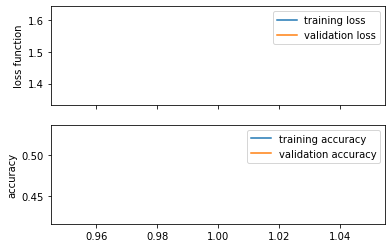

In [11]:
epochs = list(range(1,num_epochs+1))

fig, axs = plt.subplots(2,1,sharex=True)
axs[0].plot(epochs, trainer.train_losses)
axs[0].plot(epochs, trainer.test_losses)
axs[0].set_ylabel('loss function')
axs[0].legend(['training loss', 'validation loss'])
axs[1].plot(epochs, trainer.train_accuracies)
axs[1].plot(epochs, trainer.test_accuracies)
axs[1].set_ylabel('accuracy')
axs[1].legend(['training accuracy', 'validation accuracy'])

# Visualize predictions

accuracy for the presented 25 images: 0.56


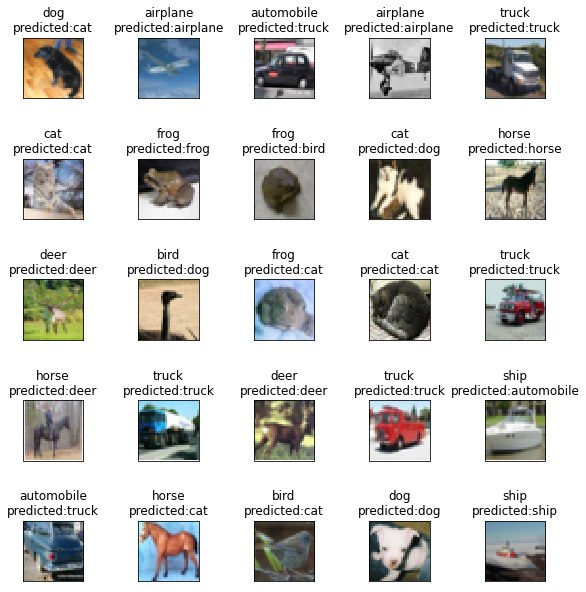

In [12]:
dataset = test_dataset

nrows = 5
ncols = 5
fig, axs = plt.subplots(nrows, ncols, squeeze=False, figsize=(10,10))

accuracy = 0

for i in range(nrows):
    for j in range(ncols):
        idx = random.randint(0,len(dataset)-1)
        prediction = trainer.predict(dataset, idx)
        prediction_name = dataset.class_names[prediction]
        _, label, label_name, ax = show_sample_image(dataset, idx,ax=axs[i,j], add_title=False)
        ax.set_title(label_name + '\npredicted:' + prediction_name)
        plt.subplots_adjust(hspace=1)
        accuracy +=1/(nrows*ncols)*float(prediction==label)
        
print('accuracy for the presented '+str(nrows*ncols)+' images: '+str(round(accuracy,2)))